In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.pandas.set_option('display.max_columns', None)

import pickle
import warnings
warnings.simplefilter(action='ignore')

import eli5

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from eli5.sklearn import PermutationImportance
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA as SK_PCA
from yellowbrick.features import pca, Rank1D, Rank2D

In [22]:
project_path = r'C:\Users\kchanas\Documents\Learning\Kaggle\Titanic'
X_train = pd.read_csv(os.path.join(project_path, r'data\X_train.csv'), index_col=0)
y_train = pd.read_csv(os.path.join(project_path, r'data\y_train.csv'), index_col=0, names=['Survived'], header=0)

X_test = pd.read_csv(os.path.join(project_path, r'data\X_test.csv'), index_col=0)
y_test = pd.read_csv(os.path.join(project_path, r'data\y_test.csv'), index_col=0, names=['Survived'], header=0)

In [23]:
X_train.shape
X_train.head()

(621, 28)

,SibSp,Parch,Fare,SibSpMinusParch,SibSpPlusParch,Alone,WithParentsOrChildren,WithSiblingsOrSpouses,Sex_enc,Embarked_enc,Title_enc,Ticket_Type_enc,Cabin_Type_enc,Age_Bucket_enc,Fare_Bucket_enc,SibSp_Bucket_enc,Parch_Bucket_enc,Pclass_enc,Sex_enc_%,Embarked_enc_%,Title_enc_%,Ticket_Type_enc_%,Cabin_Type_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,SibSp_Bucket_enc_%,Parch_Bucket_enc_%,Pclass_enc_%
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
473,0.125,0.333333,0.538164,0.363636,0.3,0.0,1.0,1.0,1.0,0.0,1.0,0.00,0.0,0.8,0.5,1.0,0.5,0.5,1.0,0.0,1.000000,0.000000,0.0,0.519473,0.503254,0.520270,0.441176,0.556117
598,0.000,0.000000,0.000000,0.454545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.4,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.091161,0.000000,0.352381,0.343348,0.000000
844,0.000,0.000000,0.321513,0.454545,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.50,0.0,0.8,0.0,0.5,0.0,0.0,0.0,1.0,0.000000,0.203784,0.0,0.519473,0.000000,0.352381,0.343348,0.000000
113,0.000,0.000000,0.352955,0.454545,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.167198,0.0,0.000000,0.000000,0.352381,0.343348,0.000000
870,0.125,0.166667,0.399934,0.454545,0.2,0.0,1.0,1.0,0.0,0.0,0.5,0.25,0.0,1.0,0.5,1.0,1.0,0.0,0.0,0.0,0.696046,0.167198,0.0,1.000000,0.503254,0.520270,0.540230,0.000000


In [24]:
y_train.head()

,Survived
473,1
598,0
844,0
113,0
870,1


In the next lines of code I will try out different methods of feature importance assesment and rank variables using each of these methods. The final subset of features will be selected basing on the sum of rankings coming from these methods.

## Feature importance based on correlation with target

In [25]:
corr = pd.concat([X_train, y_train], axis=1).corr()
corr = np.abs(corr)
imp_corr = corr['Survived'].sort_values(ascending=False).reset_index().rename(columns = 
                                                                               {'index': 'Feature', 'Survived': 'Correlation'})
imp_corr['Corr_Rank'] = imp_corr['Correlation'].rank(ascending=False) - 1
# delete SalePrice from ranking
imp_corr = imp_corr[imp_corr['Corr_Rank']>0].set_index('Feature')
imp_corr.head(30)

,Correlation,Corr_Rank
Feature,,
Title_enc_%,0.546571,1.0
Title_enc,0.540301,2.0
Sex_enc_%,0.526443,3.5
Sex_enc,0.526443,3.5
Pclass_enc_%,0.351723,5.0
Pclass_enc,0.351250,6.0
Cabin_Type_enc,0.346596,7.5
Cabin_Type_enc_%,0.346596,7.5
Fare_Bucket_enc_%,0.322339,9.0


I will eliminate variables from feature set, so that there will be no highly correlated variables. From each pair of highly correlated variables I will eliminate the one that is less correlated with Survived.

In [26]:

def filter_df_corr(inp_data, imp_corr, corr_val):
    '''
    Returns an array or dataframe (based on type(inp_data) adjusted to drop \
        columns with high correlation to one another. Takes second arg corr_val
        that defines the cutoff

    ----------
    inp_data : np.array, pd.DataFrame
        Values to consider
    corr_val : float
        Value [0, 1] on which to base the correlation cutoff
    '''
    # Creates Correlation Matrix
    if isinstance(inp_data, np.ndarray):
        inp_data = pd.DataFrame(data=inp_data)
        array_flag = True
    else:
        array_flag = False
    corr_matrix = inp_data.corr()

    # Iterates through Correlation Matrix Table to find correlated columns
    drop_cols = []
    n_cols = len(corr_matrix.columns)
    for i in range(n_cols):
        for k in range(i+1, n_cols):
            val = corr_matrix.iloc[k, i]
            col = corr_matrix.columns[i]
            row = corr_matrix.index[k]
            if abs(val) >= corr_val:
                col_corr_with_target = imp_corr.loc[col].iloc[0]
                row_corr_with_target = imp_corr.loc[row].iloc[0]
                # Prints the correlated feature set and the corr val
                print(col, "|", row, "|", round(val, 2))
                if col_corr_with_target > row_corr_with_target:
                    drop_cols.append(row)
                else:
                    drop_cols.append(col)

    # Drops the correlated columns
    drop_cols = set(drop_cols)
    print(drop_cols)
    inp_data = inp_data.drop(columns=drop_cols)
    # Return same type as inp
    if array_flag:
        return inp_data.values
    else:
        return inp_data

X_train = filter_df_corr(X_train, imp_corr, 0.8)

SibSp | SibSpPlusParch | 0.89
Parch | WithParentsOrChildren | 0.85
Fare | Fare_Bucket_enc | 0.89
Fare | Fare_Bucket_enc_% | 0.89
Alone | WithSiblingsOrSpouses | -0.83
WithParentsOrChildren | Parch_Bucket_enc | 0.94
WithParentsOrChildren | Parch_Bucket_enc_% | 0.94
Sex_enc | Title_enc | 0.93
Sex_enc | Sex_enc_% | 1.0
Sex_enc | Title_enc_% | 0.92
Embarked_enc | Embarked_enc_% | 0.99
Title_enc | Sex_enc_% | 0.93
Title_enc | Title_enc_% | 0.99
Ticket_Type_enc | Ticket_Type_enc_% | 0.95
Cabin_Type_enc | Cabin_Type_enc_% | 1.0
Age_Bucket_enc | Age_Bucket_enc_% | 0.95
Fare_Bucket_enc | Fare_Bucket_enc_% | 1.0
SibSp_Bucket_enc | SibSp_Bucket_enc_% | 0.99
Parch_Bucket_enc | Parch_Bucket_enc_% | 1.0
Pclass_enc | Pclass_enc_% | 1.0
Sex_enc_% | Title_enc_% | 0.92
{'SibSpPlusParch', 'Parch_Bucket_enc', 'SibSp_Bucket_enc', 'Parch', 'Sex_enc', 'Age_Bucket_enc', 'Fare_Bucket_enc', 'WithParentsOrChildren', 'Ticket_Type_enc', 'Cabin_Type_enc', 'Title_enc', 'Sex_enc_%', 'WithSiblingsOrSpouses', 'Embarked

In [27]:
X_train.head()

,SibSp,SibSpMinusParch,Alone,Embarked_enc_%,Title_enc_%,Ticket_Type_enc_%,Cabin_Type_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,SibSp_Bucket_enc_%,Parch_Bucket_enc_%,Pclass_enc_%
PassengerId,,,,,,,,,,,,
473,0.125,0.363636,0.0,0.0,1.000000,0.000000,0.0,0.519473,0.503254,0.520270,0.441176,0.556117
598,0.000,0.454545,1.0,0.0,0.000000,0.000000,0.0,0.091161,0.000000,0.352381,0.343348,0.000000
844,0.000,0.454545,1.0,1.0,0.000000,0.203784,0.0,0.519473,0.000000,0.352381,0.343348,0.000000
113,0.000,0.454545,1.0,0.0,0.000000,0.167198,0.0,0.000000,0.000000,0.352381,0.343348,0.000000
870,0.125,0.454545,0.0,0.0,0.696046,0.167198,0.0,1.000000,0.503254,0.520270,0.540230,0.000000


In [28]:
X_train.shape

(621, 12)

In [29]:
sm = SMOTE(sampling_strategy='auto', random_state=1)
X_train_cols = X_train.columns
X_train, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns = X_train_cols)
y_train = pd.Series(y_train['Survived'])

In [30]:
X_train.shape

(768, 12)

In [31]:
X_test = X_test.reindex(X_train.columns, axis=1)

## Feature importance using Yellowbrick

<Figure size 720x720 with 0 Axes>

Rank1D(algorithm=None, ax=<AxesSubplot:>, orient=None, show_feature_names=None)

,SibSp,SibSpMinusParch,Alone,Embarked_enc_%,Title_enc_%,Ticket_Type_enc_%,Cabin_Type_enc_%,Age_Bucket_enc_%,Fare_Bucket_enc_%,SibSp_Bucket_enc_%,Parch_Bucket_enc_%,Pclass_enc_%
PassengerId,,,,,,,,,,,,
434,0.000,0.454545,1.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.352381,0.343348,0.000000
222,0.000,0.454545,1.0,0.0,0.000000,0.167198,0.0,0.457773,0.503254,0.352381,0.343348,0.556117
218,0.125,0.545455,0.0,0.0,0.000000,0.167198,0.0,0.519473,0.503254,0.520270,0.343348,0.556117
377,0.000,0.454545,1.0,0.0,0.879035,0.000000,0.0,0.000000,0.000000,0.352381,0.343348,0.000000
448,0.000,0.454545,1.0,0.0,0.000000,0.167198,0.0,0.519473,0.503254,0.352381,0.343348,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
640,0.125,0.545455,0.0,0.0,0.000000,0.167198,0.0,0.032954,0.503254,0.520270,0.343348,0.000000
771,0.000,0.454545,1.0,0.0,0.000000,0.167198,0.0,0.000000,0.000000,0.352381,0.343348,0.000000
851,0.500,0.636364,0.0,0.0,0.696046,0.167198,0.0,1.000000,0.503254,0.226415,0.441176,0.000000


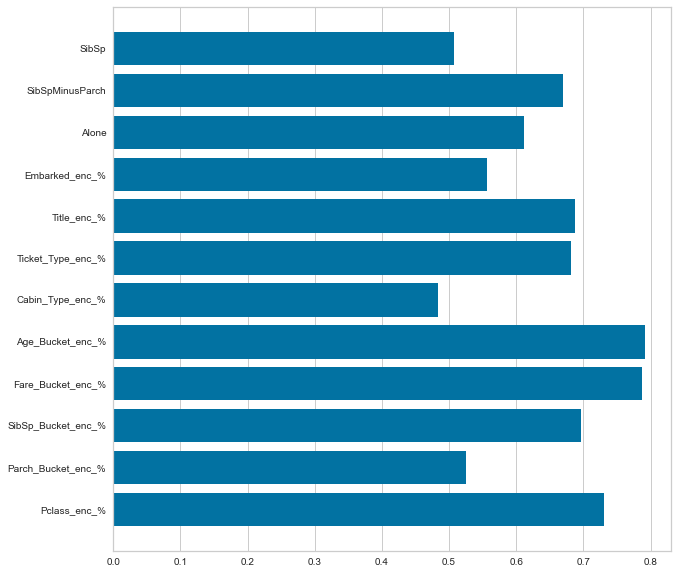

In [32]:
plt.figure(figsize=(10,10))
rank = Rank1D(algorithm='shapiro')

rank.fit(X_train, y_train)           
rank.transform(X_test) 

<Figure size 720x504 with 0 Axes>

<AxesSubplot:>

<Figure size 720x504 with 0 Axes>

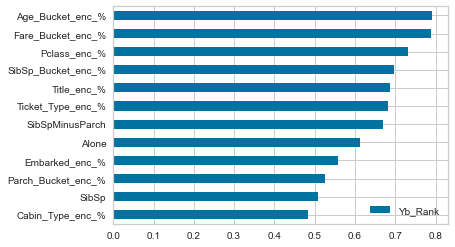

In [33]:
plt.figure(figsize=(10,7))
ranks_1d = pd.DataFrame({'Yb_Rank': rank.ranks_}, index=X_train.columns).sort_values('Yb_Rank', ascending=True)
ranks_1d.plot.barh()
ranks_1d['Yb_Selection'] = np.where(ranks_1d['Yb_Rank']>0.5, 1, 0)
yb_selection = ranks_1d['Yb_Selection']

## Feature importance from models

In [34]:
cv = KFold(n_splits=5, random_state=1)

step = 4

### Logistic Regression

In [35]:
lr = LogisticRegression(C=0.05, random_state=1, max_iter=200)
lr.fit(X_train, y_train)
perm = PermutationImportance(lr, random_state=1, cv='prefit').fit(X_test.values, y_test.values)
perm_imp_lr = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_lr = perm_imp_lr.set_index('feature')
perm_imp_lr['Perm_Lr_Rank'] = perm_imp_lr['weight'].rank(ascending=False)
perm_imp_lr.head(15)

LogisticRegression(C=0.05, max_iter=200, random_state=1)

,weight,std,Perm_Lr_Rank
feature,,,
Title_enc_%,0.198507,0.018188,1.0
Age_Bucket_enc_%,0.019403,0.004351,2.0
SibSp,0.005224,0.001828,3.0
Cabin_Type_enc_%,0.001493,0.006063,4.0
Embarked_enc_%,0.000746,0.007610,5.0
Parch_Bucket_enc_%,0.000746,0.001493,6.0
SibSp_Bucket_enc_%,0.000000,0.000000,7.5
SibSpMinusParch,0.000000,0.000000,7.5
Alone,-0.001493,0.002985,9.0


In [36]:
lr = LogisticRegression(C=0.05, random_state=1, max_iter=200)
lr.fit(X_train, y_train)

selection = RFECV(lr, min_features_to_select=5, cv=cv, scoring='roc_auc')
selection.fit(X_test, y_test)

cols = X_train.columns[selection.get_support()]
lr_selection = pd.Series([0] *len(cols), index=cols, name='Selection')
lr_selection

LogisticRegression(C=0.05, max_iter=200, random_state=1)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=LogisticRegression(C=0.05, max_iter=200, random_state=1),
      min_features_to_select=5, scoring='roc_auc')

Alone                0
Title_enc_%          0
Ticket_Type_enc_%    0
Cabin_Type_enc_%     0
Age_Bucket_enc_%     0
Fare_Bucket_enc_%    0
Pclass_enc_%         0
Name: Selection, dtype: int64

In [37]:
lr = LogisticRegression(C=0.05, random_state=1, max_iter=200)
lr.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(lr, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc')
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
lr_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
lr_selection_perm

LogisticRegression(C=0.05, max_iter=200, random_state=1)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=LogisticRegression(C=0.05,
                                                                   max_iter=200,
                                                                   random_state=1),
                                      random_state=1),
      min_features_to_select=5, scoring='roc_auc')

Alone                0
Title_enc_%          0
Age_Bucket_enc_%     0
Fare_Bucket_enc_%    0
Pclass_enc_%         0
Name: Selection_Perm, dtype: int64

In [38]:
feat_imp_lr = pd.concat([perm_imp_lr, lr_selection, lr_selection_perm, yb_selection], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_lr if 'Rank' in col] + ['Yb_Selection','Selection','Selection_Perm']
feat_imp_lr = feat_imp_lr[rank_columns]
feat_imp_lr['Overall_Rank'] = feat_imp_lr.sum(axis=1)
feat_imp_lr = feat_imp_lr.sort_values('Overall_Rank', ascending=True)
feat_imp_lr.head(30)

,Perm_Lr_Rank,Yb_Selection,Selection,Selection_Perm,Overall_Rank
Title_enc_%,1.0,1,0.0,0.0,2.0
Age_Bucket_enc_%,2.0,1,0.0,0.0,3.0
Cabin_Type_enc_%,4.0,0,0.0,5.0,9.0
Alone,9.0,1,0.0,0.0,10.0
Fare_Bucket_enc_%,11.0,1,0.0,0.0,12.0
Pclass_enc_%,12.0,1,0.0,0.0,13.0
SibSp,3.0,1,5.0,5.0,14.0
Embarked_enc_%,5.0,1,5.0,5.0,16.0
Ticket_Type_enc_%,10.0,1,0.0,5.0,16.0
Parch_Bucket_enc_%,6.0,1,5.0,5.0,17.0


In [39]:
lr_selected_features = feat_imp_lr[(feat_imp_lr['Overall_Rank']<=16) & (feat_imp_lr['Yb_Selection']==1)].index.tolist()
print(lr_selected_features)

['Title_enc_%', 'Age_Bucket_enc_%', 'Alone', 'Fare_Bucket_enc_%', 'Pclass_enc_%', 'SibSp', 'Embarked_enc_%', 'Ticket_Type_enc_%']


### KNeighbors

In [40]:
kn = KNeighborsClassifier(n_neighbors=20)
kn.fit(X_train, y_train)
perm = PermutationImportance(kn, random_state=1, cv='prefit').fit(X_test.values, y_test.values)
perm_imp_kn = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_kn = perm_imp_kn.set_index('feature')
perm_imp_kn['Perm_Kn_Rank'] = perm_imp_kn['weight'].rank(ascending=False)
perm_imp_kn.head(15)

KNeighborsClassifier(n_neighbors=20)

,weight,std,Perm_Kn_Rank
feature,,,
Title_enc_%,0.211940,0.022188,1.0
Embarked_enc_%,0.015672,0.002792,2.0
Alone,0.008209,0.008310,3.0
SibSp_Bucket_enc_%,0.003731,0.003337,4.0
SibSp,0.001493,0.003805,5.0
SibSpMinusParch,0.001493,0.001828,6.0
Age_Bucket_enc_%,-0.001493,0.005585,7.0
Pclass_enc_%,-0.003731,0.011069,8.0
Cabin_Type_enc_%,-0.005224,0.006921,9.0


In [41]:
kn = KNeighborsClassifier(n_neighbors=20)
kn.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(kn, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
kn_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
kn_selection_perm

KNeighborsClassifier(n_neighbors=20)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=KNeighborsClassifier(n_neighbors=20),
                                      random_state=1),
      min_features_to_select=5, scoring='roc_auc', step=4)

SibSp                0
Alone                0
Embarked_enc_%       0
Title_enc_%          0
Ticket_Type_enc_%    0
Age_Bucket_enc_%     0
Fare_Bucket_enc_%    0
Pclass_enc_%         0
Name: Selection_Perm, dtype: int64

In [42]:
feat_imp_kn = pd.concat([perm_imp_kn, kn_selection_perm, yb_selection], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_kn if 'Rank' in col] + ['Yb_Selection','Selection_Perm']
feat_imp_kn = feat_imp_kn[rank_columns]
feat_imp_kn['Overall_Rank'] = feat_imp_kn.sum(axis=1)
feat_imp_kn = feat_imp_kn.sort_values('Overall_Rank', ascending=True)
feat_imp_kn.head(30)

,Perm_Kn_Rank,Yb_Selection,Selection_Perm,Overall_Rank
Title_enc_%,1.0,1,0.0,2.0
Embarked_enc_%,2.0,1,0.0,3.0
Alone,3.0,1,0.0,4.0
SibSp,5.0,1,0.0,6.0
Age_Bucket_enc_%,7.0,1,0.0,8.0
Pclass_enc_%,8.0,1,0.0,9.0
SibSp_Bucket_enc_%,4.0,1,5.0,10.0
SibSpMinusParch,6.0,1,5.0,12.0
Fare_Bucket_enc_%,11.0,1,0.0,12.0
Ticket_Type_enc_%,12.0,1,0.0,13.0


In [43]:
kn_selected_features = feat_imp_kn[(feat_imp_kn['Overall_Rank']<=9.5)].index.tolist()
print(kn_selected_features)

['Title_enc_%', 'Embarked_enc_%', 'Alone', 'SibSp', 'Age_Bucket_enc_%', 'Pclass_enc_%']


### SVC

In [44]:
svc = SVC(C=0.6, probability=True)
svc.fit(X_train, y_train)
perm = PermutationImportance(svc, random_state=1, cv='prefit').fit(X_test.values, y_test.values)
perm_imp_svc = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_svc = perm_imp_svc.set_index('feature')
perm_imp_svc['Perm_Svc_Rank'] = perm_imp_svc['weight'].rank(ascending=False)
perm_imp_svc.head(15)

SVC(C=0.6, probability=True)

,weight,std,Perm_Svc_Rank
feature,,,
Title_enc_%,0.241045,0.020922,1.0
SibSp,0.023134,0.003656,2.0
Ticket_Type_enc_%,0.011194,0.000000,3.0
Pclass_enc_%,0.009701,0.003805,4.0
Age_Bucket_enc_%,0.008955,0.002985,5.0
SibSp_Bucket_enc_%,0.007463,0.000000,6.0
Embarked_enc_%,0.005970,0.006063,7.0
Parch_Bucket_enc_%,0.003731,0.000000,8.5
SibSpMinusParch,0.003731,0.000000,8.5


In [45]:
svc = SVC(C=0.6, probability=True)
svc.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(svc, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
svc_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
svc_selection_perm

SVC(C=0.6, probability=True)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=SVC(C=0.6, probability=True),
                                      random_state=1),
      min_features_to_select=5, scoring='roc_auc', step=4)

SibSp                 0
SibSpMinusParch       0
Alone                 0
Embarked_enc_%        0
Title_enc_%           0
Ticket_Type_enc_%     0
Cabin_Type_enc_%      0
Age_Bucket_enc_%      0
Fare_Bucket_enc_%     0
SibSp_Bucket_enc_%    0
Parch_Bucket_enc_%    0
Pclass_enc_%          0
Name: Selection_Perm, dtype: int64

In [46]:
feat_imp_svc = pd.concat([perm_imp_svc, svc_selection_perm, yb_selection], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_svc if 'Rank' in col] + ['Yb_Selection','Selection_Perm']
feat_imp_svc = feat_imp_svc[rank_columns]
feat_imp_svc['Overall_Rank'] = feat_imp_svc.sum(axis=1)
feat_imp_svc = feat_imp_svc.sort_values('Overall_Rank', ascending=True)
feat_imp_svc.head(30)

,Perm_Svc_Rank,Yb_Selection,Selection_Perm,Overall_Rank
Title_enc_%,1.0,1,0,2.0
SibSp,2.0,1,0,3.0
Ticket_Type_enc_%,3.0,1,0,4.0
Pclass_enc_%,4.0,1,0,5.0
Age_Bucket_enc_%,5.0,1,0,6.0
SibSp_Bucket_enc_%,6.0,1,0,7.0
Embarked_enc_%,7.0,1,0,8.0
Parch_Bucket_enc_%,8.5,1,0,9.5
SibSpMinusParch,8.5,1,0,9.5
Cabin_Type_enc_%,10.0,0,0,10.0


In [47]:
svc_selected_features = feat_imp_svc[(feat_imp_svc['Yb_Selection']==1) & (feat_imp_svc['Overall_Rank']<=12)].index.tolist()
print(svc_selected_features)

['Title_enc_%', 'SibSp', 'Ticket_Type_enc_%', 'Pclass_enc_%', 'Age_Bucket_enc_%', 'SibSp_Bucket_enc_%', 'Embarked_enc_%', 'Parch_Bucket_enc_%', 'SibSpMinusParch', 'Fare_Bucket_enc_%']


### RandomForest

In [48]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=1, max_depth=10)
rf.fit(X_train, y_train)
perm = PermutationImportance(rf, random_state=1, cv='prefit').fit(X_test.values, y_test.values)
perm_imp_rf = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_rf = perm_imp_rf.set_index('feature')
perm_imp_rf['Perm_Rf_Rank'] = perm_imp_rf['weight'].rank(ascending=False)
perm_imp_rf.head(15)

RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=1)

,weight,std,Perm_Rf_Rank
feature,,,
Title_enc_%,0.215672,0.026109,1.0
Age_Bucket_enc_%,0.011940,0.005484,2.0
Pclass_enc_%,0.005970,0.009017,3.0
SibSp,0.000746,0.006420,4.0
Cabin_Type_enc_%,-0.000746,0.005970,5.0
Embarked_enc_%,-0.002239,0.010178,6.0
Fare_Bucket_enc_%,-0.003731,0.006675,7.0
Parch_Bucket_enc_%,-0.005970,0.001828,8.0
Alone,-0.006716,0.003656,9.0


In [49]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=1, max_depth=10)
rf.fit(X_train, y_train)

selection = RFECV(rf, min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection.fit(X_test, y_test)

cols = X_train.columns[selection.get_support()]
rf_selection = pd.Series([0] *len(cols), index=cols, name='Selection')
rf_selection

RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=1)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=RandomForestClassifier(max_depth=10, n_estimators=200,
                                       oob_score=True, random_state=1),
      min_features_to_select=5, scoring='roc_auc', step=4)

SibSp                0
SibSpMinusParch      0
Embarked_enc_%       0
Title_enc_%          0
Ticket_Type_enc_%    0
Age_Bucket_enc_%     0
Fare_Bucket_enc_%    0
Pclass_enc_%         0
Name: Selection, dtype: int64

In [50]:
rf = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=1, max_depth=10)
rf.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(rf, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
rf_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
rf_selection_perm

RandomForestClassifier(max_depth=10, n_estimators=200, oob_score=True,
                       random_state=1)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=RandomForestClassifier(max_depth=10,
                                                                       n_estimators=200,
                                                                       oob_score=True,
                                                                       random_state=1),
                                      random_state=1),
      min_features_to_select=5, scoring='roc_auc', step=4)

SibSpMinusParch      0
Embarked_enc_%       0
Title_enc_%          0
Age_Bucket_enc_%     0
Fare_Bucket_enc_%    0
Name: Selection_Perm, dtype: int64

In [51]:
feat_imp_rf = pd.concat([perm_imp_rf, rf_selection, rf_selection_perm, yb_selection], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_rf if 'Rank' in col] + ['Yb_Selection','Selection', 'Selection_Perm']
feat_imp_rf = feat_imp_rf[rank_columns]
feat_imp_rf['Overall_Rank'] = feat_imp_rf.sum(axis=1)
feat_imp_rf = feat_imp_rf.sort_values('Overall_Rank', ascending=True)
feat_imp_rf.head(30)

,Perm_Rf_Rank,Yb_Selection,Selection,Selection_Perm,Overall_Rank
Title_enc_%,1.0,1,0.0,0.0,2.0
Age_Bucket_enc_%,2.0,1,0.0,0.0,3.0
Embarked_enc_%,6.0,1,0.0,0.0,7.0
Fare_Bucket_enc_%,7.0,1,0.0,0.0,8.0
Pclass_enc_%,3.0,1,0.0,5.0,9.0
SibSp,4.0,1,0.0,5.0,10.0
SibSpMinusParch,11.0,1,0.0,0.0,12.0
Cabin_Type_enc_%,5.0,0,5.0,5.0,15.0
Ticket_Type_enc_%,10.0,1,0.0,5.0,16.0
Parch_Bucket_enc_%,8.0,1,5.0,5.0,19.0


In [52]:
rf_selected_features = feat_imp_rf[(feat_imp_rf['Overall_Rank']<=13.5)].index.tolist()
print(rf_selected_features)

['Title_enc_%', 'Age_Bucket_enc_%', 'Embarked_enc_%', 'Fare_Bucket_enc_%', 'Pclass_enc_%', 'SibSp', 'SibSpMinusParch']


### XGB

In [53]:
xgb = XGBClassifier(n_estimators=200, random_state=1, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
perm = PermutationImportance(xgb, random_state=1, cv=cv).fit(X_test.values, y_test.values)
perm_imp_xgb = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist(), top=100)
perm_imp_xgb = perm_imp_xgb.set_index('feature')
perm_imp_xgb['Perm_Xgb_Rank'] = perm_imp_xgb['weight'].rank(ascending=False)
perm_imp_xgb.head(15)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

,weight,std,Perm_Xgb_Rank
feature,,,
Title_enc_%,0.167925,0.066155,1.0
Embarked_enc_%,0.012732,0.035661,2.0
Fare_Bucket_enc_%,0.008260,0.029330,3.0
SibSp,0.004472,0.021863,4.0
Pclass_enc_%,0.000797,0.047777,5.0
Alone,-0.003690,0.028218,6.0
Cabin_Type_enc_%,-0.003774,0.030210,7.0
SibSp_Bucket_enc_%,-0.005269,0.017870,8.0
Ticket_Type_enc_%,-0.005954,0.026714,9.0


In [54]:
xgb = XGBClassifier(n_estimators=200, random_state=1, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)
selection = RFECV(xgb, min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection.fit(X_test, y_test)

cols = X_train.columns[selection.get_support()]
xgb_selection = pd.Series([0] *len(cols), index=cols, name='Selection')
xgb_selection

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=200,
                              n_jobs=0, num_parallel_tree=1, random_state=1,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None),
      min_features_to_select=5, scoring='roc_auc', step=4)

SibSp                 0
Alone                 0
Embarked_enc_%        0
Title_enc_%           0
Ticket_Type_enc_%     0
Cabin_Type_enc_%      0
Parch_Bucket_enc_%    0
Pclass_enc_%          0
Name: Selection, dtype: int64

In [55]:
xgb = XGBClassifier(n_estimators=200, random_state=1, max_depth=10, learning_rate=0.1)
xgb.fit(X_train, y_train)

selection_perm = RFECV(PermutationImportance(xgb, random_state=1, cv=cv)
                       , min_features_to_select=5, cv=cv, scoring='roc_auc', step=step)
selection_perm.fit(X_test, y_test)

cols = X_train.columns[selection_perm.get_support()]
xgb_selection_perm = pd.Series([0] *len(cols), index=cols, name='Selection_Perm')
xgb_selection_perm

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

RFECV(cv=KFold(n_splits=5, random_state=1, shuffle=False),
      estimator=PermutationImportance(cv=KFold(n_splits=5, random_state=1, shuffle=False),
                                      estimator=XGBClassifier(base_score=0.5,
                                                              booster='gbtree',
                                                              colsample_bylevel=1,
                                                              colsample_bynode=1,
                                                              colsample_bytree=1,
                                                              gamma=0,
                                                              gpu_id=-1,
                                                              importance_type='gain',
                                                              interaction_constraints='',
                                                              learning_rate=0.1,
                                            

SibSpMinusParch       0
Title_enc_%           0
Ticket_Type_enc_%     0
Fare_Bucket_enc_%     0
SibSp_Bucket_enc_%    0
Name: Selection_Perm, dtype: int64

In [56]:
feat_imp_xgb = pd.concat([perm_imp_xgb, xgb_selection, xgb_selection_perm, yb_selection], axis=1).fillna(5)
rank_columns = [col for col in feat_imp_xgb if 'Rank' in col] + ['Yb_Selection','Selection','Selection_Perm']
feat_imp_xgb = feat_imp_xgb[rank_columns]
feat_imp_xgb['Overall_Rank'] = feat_imp_xgb.sum(axis=1)
feat_imp_xgb = feat_imp_xgb.sort_values('Overall_Rank', ascending=True)
feat_imp_xgb.head(30)

,Perm_Xgb_Rank,Yb_Selection,Selection,Selection_Perm,Overall_Rank
Title_enc_%,1.0,1,0.0,0.0,2.0
Embarked_enc_%,2.0,1,0.0,5.0,8.0
Fare_Bucket_enc_%,3.0,1,5.0,0.0,9.0
SibSp,4.0,1,0.0,5.0,10.0
Ticket_Type_enc_%,9.0,1,0.0,0.0,10.0
Pclass_enc_%,5.0,1,0.0,5.0,11.0
Alone,6.0,1,0.0,5.0,12.0
Cabin_Type_enc_%,7.0,0,0.0,5.0,12.0
SibSp_Bucket_enc_%,8.0,1,5.0,0.0,14.0
SibSpMinusParch,10.0,1,5.0,0.0,16.0


In [57]:
xgb_selected_features = feat_imp_xgb[(feat_imp_rf['Overall_Rank']<=16)].index.tolist()
print(xgb_selected_features)

['Title_enc_%', 'Embarked_enc_%', 'Fare_Bucket_enc_%', 'SibSp', 'Ticket_Type_enc_%', 'Pclass_enc_%', 'Cabin_Type_enc_%', 'SibSpMinusParch', 'Age_Bucket_enc_%']


In [58]:
for features in [svc_selected_features, lr_selected_features, kn_selected_features, rf_selected_features, xgb_selected_features]:
    print(features)

['Title_enc_%', 'SibSp', 'Ticket_Type_enc_%', 'Pclass_enc_%', 'Age_Bucket_enc_%', 'SibSp_Bucket_enc_%', 'Embarked_enc_%', 'Parch_Bucket_enc_%', 'SibSpMinusParch', 'Fare_Bucket_enc_%']
['Title_enc_%', 'Age_Bucket_enc_%', 'Alone', 'Fare_Bucket_enc_%', 'Pclass_enc_%', 'SibSp', 'Embarked_enc_%', 'Ticket_Type_enc_%']
['Title_enc_%', 'Embarked_enc_%', 'Alone', 'SibSp', 'Age_Bucket_enc_%', 'Pclass_enc_%']
['Title_enc_%', 'Age_Bucket_enc_%', 'Embarked_enc_%', 'Fare_Bucket_enc_%', 'Pclass_enc_%', 'SibSp', 'SibSpMinusParch']
['Title_enc_%', 'Embarked_enc_%', 'Fare_Bucket_enc_%', 'SibSp', 'Ticket_Type_enc_%', 'Pclass_enc_%', 'Cabin_Type_enc_%', 'SibSpMinusParch', 'Age_Bucket_enc_%']


In [61]:
all_selected_features = X_train.columns.tolist()

In [62]:
with open(os.path.join(project_path, r'data\svc_selected_features.txt'), "wb") as f:
      pickle.dump(svc_selected_features, f)
with open(os.path.join(project_path, r'data\lr_selected_features.txt'), "wb") as f:
      pickle.dump(lr_selected_features, f)
with open(os.path.join(project_path, r'data\kn_selected_features.txt'), "wb") as f:
      pickle.dump(kn_selected_features, f)
with open(os.path.join(project_path, r'data\rf_selected_features.txt'), "wb") as f:
      pickle.dump(rf_selected_features, f)
with open(os.path.join(project_path, r'data\xgb_selected_features.txt'), "wb") as f:
      pickle.dump(xgb_selected_features, f)
with open(os.path.join(project_path, r'data\all_selected_features.txt'), "wb") as f:
      pickle.dump(all_selected_features, f)